In [1]:
import pandas as pd

In [2]:
#Data file reading
try:
    pse_isr_df=pd.read_csv(r"pse_isr_reddit_comments.csv")
except Exception as e:
    print("Exception while reading file",e)

In [3]:
#Data Exploration
pse_isr_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 513557 entries, 0 to 513556
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_id    513557 non-null  object
 1   score         513557 non-null  int64 
 2   self_text     513555 non-null  object
 3   subreddit     513557 non-null  object
 4   created_time  513557 non-null  object
dtypes: int64(1), object(4)
memory usage: 19.6+ MB


In [4]:
pse_isr_df['self_text'].head(5)

0                                                    k
1    What is he firing? Looks home made? And what i...
2    I mean you did run away from the question firs...
3    There is a difference between footage showing ...
4                             Not feeding you anymore.
Name: self_text, dtype: object

In [5]:
null_counts = pse_isr_df.isnull().sum()
print("Total number of null values in the DataFrame: ", null_counts)
pse_isr_df=pse_isr_df.dropna()
pse_isr_df.count()



Total number of null values in the DataFrame:  comment_id      0
score           0
self_text       2
subreddit       0
created_time    0
dtype: int64


comment_id      513555
score           513555
self_text       513555
subreddit       513555
created_time    513555
dtype: int64

In [6]:
#Added new column 'vote' which shows upvote and downvote for the comment based on the score.
pse_isr_df['vote']=pse_isr_df['score'].apply(lambda x: 'Upvote' if x>0 else 'Downvote')
#pse_isr_df['vote']=pse_isr_df['score'].apply(lambda x: 'Upvote' if x>0 else ('Downvote' if x<0 else 'Neutral'))
pse_isr_df.head(5)


comment_id  score                                          self_text  \
0    k7kxio7      1                                                  k   
1    k7kxho7      1  What is he firing? Looks home made? And what i...   
2    k7kxhem      1  I mean you did run away from the question firs...   
3    k7kxgzg      2  There is a difference between footage showing ...   
4    k7kxgne      1                           Not feeding you anymore.   

       subreddit               created_time    vote  
0  CombatFootage  2023-11-02 23:49:37+00:00  Upvote  
1  CombatFootage  2023-11-02 23:49:25+00:00  Upvote  
2  CombatFootage  2023-11-02 23:49:22+00:00  Upvote  
3  CombatFootage  2023-11-02 23:49:18+00:00  Upvote  
4  CombatFootage  2023-11-02 23:49:14+00:00  Upvote

In [7]:
#Using Labelencoder to convert the labels of upvote as 1 and Downvote to 0.
from sklearn.preprocessing import LabelEncoder


vote = pse_isr_df['vote'].values

encoder = LabelEncoder()
encoded_vote = encoder.fit_transform(vote)
pse_isr_df['EncodedVote']=encoded_vote
pse_isr_df.head(5)

comment_id  score                                          self_text  \
0    k7kxio7      1                                                  k   
1    k7kxho7      1  What is he firing? Looks home made? And what i...   
2    k7kxhem      1  I mean you did run away from the question firs...   
3    k7kxgzg      2  There is a difference between footage showing ...   
4    k7kxgne      1                           Not feeding you anymore.   

       subreddit               created_time    vote  EncodedVote  
0  CombatFootage  2023-11-02 23:49:37+00:00  Upvote            1  
1  CombatFootage  2023-11-02 23:49:25+00:00  Upvote            1  
2  CombatFootage  2023-11-02 23:49:22+00:00  Upvote            1  
3  CombatFootage  2023-11-02 23:49:18+00:00  Upvote            1  
4  CombatFootage  2023-11-02 23:49:14+00:00  Upvote            1

In [8]:
#Check whether the data is balanced or not
pse_isr_df['EncodedVote'].value_counts()

#Data is highly imbalanced

1    449005
0     64550
Name: EncodedVote, dtype: int64

In [9]:
import nltk
import re
from bs4 import BeautifulSoup
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [10]:
#Data Cleaning before model building

# Initialize the lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    
    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    
    # Remove special characters and lowercase the text
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    
    # Tokenization
    tokens = word_tokenize(text)
    
    # Lemmatization and removing stopwords
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    
    # Join the tokens back into a sentence
    cleaned_text = ' '.join(tokens)
    
    return cleaned_text


pse_isr_df['clean_text'] = pse_isr_df['self_text'].apply(clean_text)
pse_isr_df['clean_text']

C:\Users\jayda\AppData\Local\Temp\ipykernel_9068\1385073975.py:12: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, 'html.parser')


0                                                         k
1                             firing look home made outcome
2                         mean run away question first time
3         difference footage showing terrorist activity ...
4                                           feeding anymore
                                ...                        
513552                                           u bullshit
513553    united state dotted west bank gaza strip altho...
513554    country sometimes map adapt country view matte...
513555    cant give something pretended support cynical ...
513556    head islamic jihad denounced arab attempt norm...
Name: clean_text, Length: 513555, dtype: object

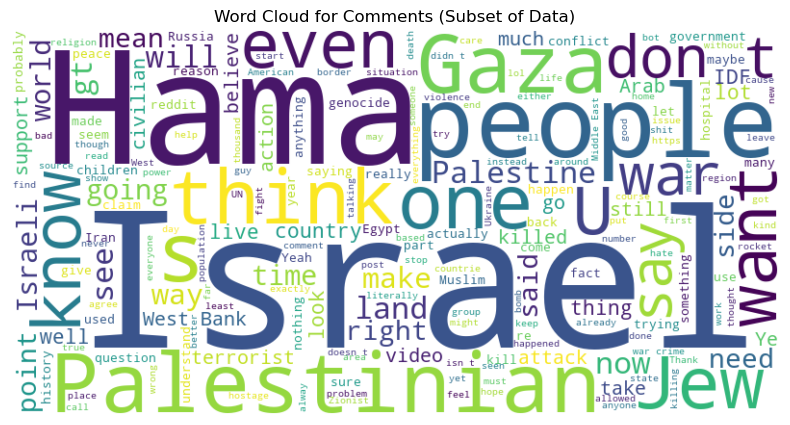

In [11]:
# adding a word cloud
from wordcloud import WordCloud
from matplotlib import pyplot as plt

subset_text = ' '.join(pse_isr_df['self_text'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(subset_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Comments (Subset of Data)')
plt.show()

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=5000)  # Adjust max_features as needed
X = vectorizer.fit_transform(pse_isr_df['clean_text'])
y = pse_isr_df['vote']

In [14]:
pse_isr_df['clean_text']

0                                                         k
1                             firing look home made outcome
2                         mean run away question first time
3         difference footage showing terrorist activity ...
4                                           feeding anymore
                                ...                        
513552                                           u bullshit
513553    united state dotted west bank gaza strip altho...
513554    country sometimes map adapt country view matte...
513555    cant give something pretended support cynical ...
513556    head islamic jihad denounced arab attempt norm...
Name: clean_text, Length: 513555, dtype: object

In [15]:

from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  
from collections import Counter
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Applying SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

# Model Training
clf = RandomForestClassifier(n_estimators=50, min_samples_split=4, min_samples_leaf=2, n_jobs=-1, random_state=42)
clf.fit(X_train_sm, y_train_sm)

# Making Predictions
y_pred = clf.predict(X_test)

In [16]:
n_samples_to_view = 5 
print(X_train[:n_samples_to_view])

  (0, 1089)	0.36823370982846243
  (0, 2449)	0.3331147354210099
  (0, 3796)	0.24383554082164405
  (0, 808)	0.48471121144500046
  (0, 941)	0.2113620423851126
  (0, 3020)	0.37096854305236165
  (0, 2414)	0.23360992785921209
  (0, 1425)	0.2784637186555345
  (0, 282)	0.1648336994518816
  (0, 319)	0.24473436706294596
  (0, 3140)	0.23992812617312664
  (1, 2568)	1.0
  (2, 1427)	0.35027071598865483
  (2, 1783)	0.25166671923270406
  (2, 4060)	0.25322133449954415
  (2, 3151)	0.27791715037754666
  (2, 1634)	0.2619368027804851
  (2, 1829)	0.29328627885012243
  (2, 4420)	0.32683445327048555
  (2, 863)	0.18760476076828386
  (2, 3302)	0.3295798122740919
  (2, 4949)	0.1669606961688658
  (2, 3231)	0.15678631422812514
  (2, 3288)	0.3334347095253247
  (2, 2831)	0.24477035930689733
  :	:
  (3, 3154)	0.2851512177164999
  (3, 938)	0.20704125471803872
  (3, 2685)	0.2562577289644206
  (3, 4843)	0.14939724481864433
  (3, 1505)	0.18363930157325078
  (3, 2683)	0.1669325630066829
  (3, 2789)	0.14419362749505668
  (

In [17]:

# dont run, use only to show output. 
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE  
from collections import Counter

print("Class distribution before SMOTE:", Counter(y_train))

# Apply SMOTE
smote = SMOTE()
Xtrain_sm, ytrain_sm = smote.fit_resample(X_train, y_train)

# Display the class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(ytrain_sm))
 

Class distribution before SMOTE: Counter({'Upvote': 314379, 'Downvote': 45109})
Class distribution after SMOTE: Counter({'Upvote': 314379, 'Downvote': 314379})


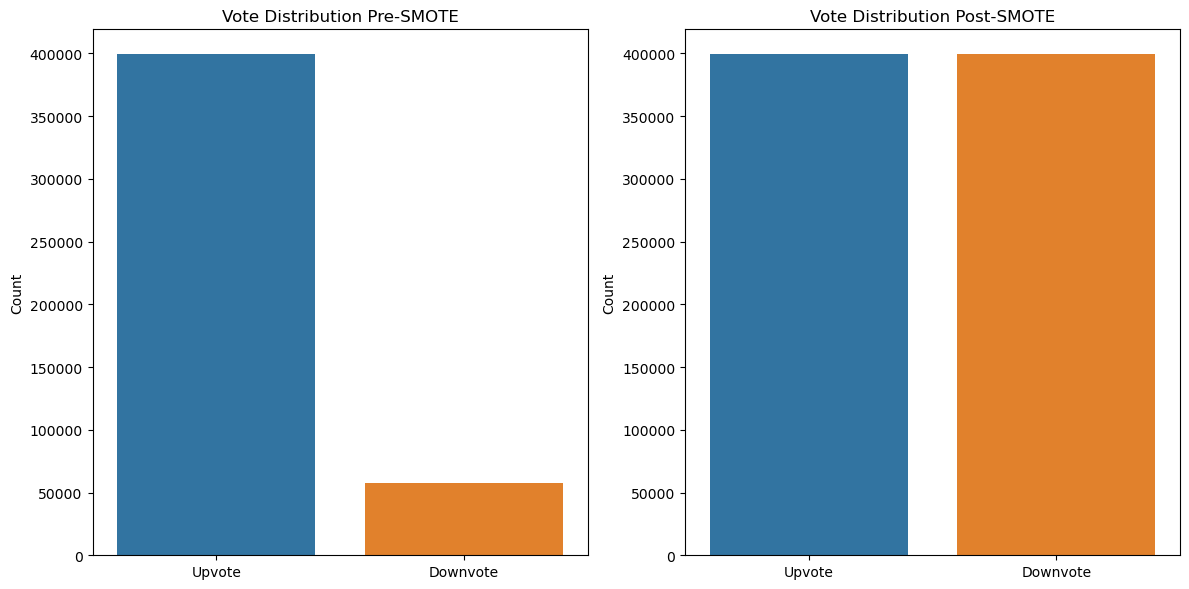

In [18]:

import seaborn as sns

votes_pre_smote = {"Upvote": 399104, "Downvote": 57919}
votes_post_smote = {"Upvote": 399104, "Downvote": 399104}


fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Pre SMOTE
sns.barplot(x=list(votes_pre_smote.keys()), y=list(votes_pre_smote.values()), ax=ax[0])
ax[0].set_title('Vote Distribution Pre-SMOTE')
ax[0].set_ylabel('Count')

# Post SMOTE
sns.barplot(x=list(votes_post_smote.keys()), y=list(votes_post_smote.values()), ax=ax[1])
ax[1].set_title('Vote Distribution Post-SMOTE')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()


In [19]:
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Classification Report: \n{classification_rep}')
print(f'Confusion Matrix: \n{conf_matrix}')

Accuracy: 0.8259458547255415
Classification Report: 
              precision    recall  f1-score   support

    Downvote       0.16      0.09      0.11     19441
      Upvote       0.88      0.93      0.90    134626

    accuracy                           0.83    154067
   macro avg       0.52      0.51      0.51    154067
weighted avg       0.79      0.83      0.80    154067

Confusion Matrix: 
[[  1668  17773]
 [  9043 125583]]


In [20]:
msg = input("Enter Message: ")
preprocessed_msg = clean_text(msg)

msg_input = vectorizer.transform([preprocessed_msg])
predict = clf.predict(msg_input)

if predict[0] == 'Upvote':
    print("Likely to get an Upvote")
else:
    print("Likely to get a Downvote")


probabilities = clf.predict_proba(msg_input)

# Assuming the second class corresponds to 'Upvote'
# and the first class corresponds to 'Downvote'
upvote_probability = probabilities[0][1] * 100
downvote_probability = probabilities[0][0] * 100

# Displaying the results
print(f"Probability of getting an Upvote: {upvote_probability:.2f}%")
print(f"Probability of getting a Downvote: {downvote_probability:.2f}%")

Enter Message: attack
Likely to get an Upvote
Probability of getting an Upvote: 84.13%
Probability of getting a Downvote: 15.87%


In [21]:
# saving th model

# from joblib import dump

# dump(clf, 'reddit_upvote_downvote_model.joblib') #save model
# dump(vectorizer, 'tfidf_vectorizer.joblib') # saving vectors

In [24]:
import lime
import lime.lime_tabular

In [25]:
from lime import lime_tabular

# Assuming X_train is a sparse matrix
# Create the LIME explainer
explainer = lime_tabular.LimeTabularExplainer(
    X_train,  # Use the original sparse matrix here
    mode='regression', 
    feature_names=None,  # Set feature_names to None, as LimeTabularExplainer can handle sparse matrices
    class_names=['MEDV'], 
    verbose=True,
    discretize_continuous=False  # Important: Do not discretize for sparse data
)


In [26]:
# Choose a random instance from the test set for explanation
import numpy as np
#instance_idx = np.random.randint(0, X_test.shape[0])
instance_idx=5
instance_to_explain = X_test[instance_idx]

# Get the model's prediction for the instance
prediction = clf.predict_proba(instance_to_explain.reshape(1, -1))

# Explain the prediction using LIME
exp = explainer.explain_instance(instance_to_explain, clf.predict_proba, num_features=X_train.shape[1])
x
# Display the explanation
exp.show_in_notebook(show_all=False)


Intercept 0.8627390689624703
Prediction_local [0.89708529]
Right: 0.15938126836887587


In [28]:
# Choose a random instance from the test set for explanation
import numpy as np
#instance_idx = np.random.randint(0, X_test.shape[0])
instance_idx=10
instance_to_explain = X_test[instance_idx]

# Get the model's prediction for the instance
prediction = clf.predict_proba(instance_to_explain.reshape(1, -1))

# Explain the prediction using LIME
exp = explainer.explain_instance(instance_to_explain, clf.predict_proba, num_features=X_train.shape[1])

# Display the explanation
exp.show_in_notebook(show_all=False)


Intercept 0.6156355402762624
Prediction_local [0.62024176]
Right: 0.19648324665947198


In [29]:
# Choose a random instance from the test set for explanation
import numpy as np
#instance_idx = np.random.randint(0, X_test.shape[0])
instance_idx=20
instance_to_explain = X_test[instance_idx]

# Get the model's prediction for the instance
prediction = clf.predict_proba(instance_to_explain.reshape(1, -1))

# Explain the prediction using LIME
exp = explainer.explain_instance(instance_to_explain, clf.predict_proba, num_features=X_train.shape[1])

# Display the explanation
exp.show_in_notebook(show_all=False)

Intercept 0.4564825655413908
Prediction_local [0.4564184]
Right: 0.15162864542745697
